# A Quick Start of NimbusML - Classification

In this example, we solve a simple binary classification problem using synthetic data. Each data sample has two features, X and Y, and the model predicts if this sample belongs to class 0 or 1. We use an ensemble learner based on the FastTreeBinaryClassifier from nimbusml (python binding for ML.NET) as demonstration.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display,IFrame,Image, HTML
from nimbusml.ensemble import FastForestBinaryClassifier

We develop two helper functions: one for generating the synthetic data, and one for visualizing the prediction results.

In [2]:
def gen_data(N):
    t = np.random.rand(N)
    x = t * np.cos(np.pi * t) + np.random.normal(0, t / 5, N)
    y = t * np.sin(np.pi * t) + np.random.normal(0, t / 5, N)    
    
    t = np.random.rand(N)
    x2 = t * np.cos(np.pi * t + np.pi/2) + np.random.normal(0, t / 5, N)
    y2 = t * np.sin(np.pi * t + np.pi/2) + np.random.normal(0, t / 5, N)
    
    data = pd.DataFrame(x, columns = ["X"])
    data["Y"] = y
    data["Label"] = 0
    
    data2 = pd.DataFrame(x2, columns = ["X"])
    data2["Y"] = y2
    data2["Label"] = 1
    
    data = pd.concat([data,data2])
    
    data = data.sample(frac=1)
    return data.iloc[0:int(2 * N * 0.8),0:2], data.iloc[0:int(2 * N * 0.8),2], data.iloc[int(2 * N * 0.8):,0:2], data.iloc[int(2 * N * 0.8):, 2]

def plot_result(model, data, label):
    xx, yy = np.meshgrid(np.arange(-2,1,0.01),np.arange(-2,2,0.01))
    xx1 = np.array(xx).flatten()
    yy1 = np.array(yy).flatten()
    _predict = np.array(model.predict(pd.DataFrame({"X": xx1, "Y": yy1})))

    plt.figure(figsize=(8,8))
    plt.contourf(xx,yy,_predict.reshape((400,300)), alpha = 0.2)
    plt.scatter(data["X"], data["Y"], c = label)
    plt.show()

## Introduction

In this example, we generate input data randomly with two dimensions (X,Y) and two classes. Our goal is to train a classifier that takes the input of the two features (X,Y) and gives a prediction of the class the sample belongs to, i.e. purple or yellow (0 or 1) class. For example,


                                            input: (0.75,2) ---> output: 0

In [3]:
# Loading data
np.random.seed(0)
dataTrain, labelTrain, dataTest, labelTest = gen_data(1000)
plt.figure(figsize=(6,6))
plt.scatter(dataTrain["X"], dataTrain["Y"], c = labelTrain)
plt.xlabel("X")
plt.ylabel("Y");

### Fast Trees Binary Classifier

In nimbusml, we implement the ensemble version of FastTree developed by Burges (2010), i.e. LambdaMART. An ensemble method usually consists of a number of basic learners. Each learner uses as input the features describing the data point and maps it to a prediction. The prediction result from each basic learner will be then aggregated, such as taking the average, for the final estimation. The algorithm implemented in this ensemble FastTree uses decision trees as basic learners. 

Given the input features of each training data, a decision tree is developed from the root node by introducing partitions with a threshold with respect to one specific dimension of the feature. The training starts from having all the samples reside on the same root node. Then the root node will be split into two child nodes by the threshold for the specific dimension thus seperates the data samples. The following figure shows one example of the decision tree to classify 5 data points with three features.

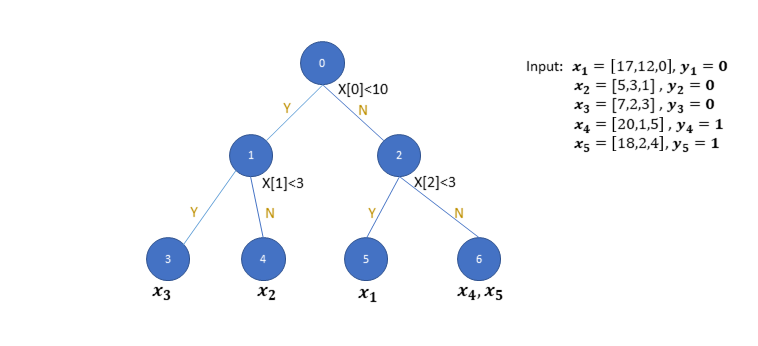

In [4]:
display(Image(filename='images/DecisionTree.png'))

At the root node, Node 0, the partition is based on the first dimension of the input feature and the threshold is set to 10. After this partition, data samples are split into two sets, i.e. x₂, x₃ reside on Node 1 and x₁,x₄,x₅ reside on Node 2. Recursively, starting from the set of samples on Node 1, a new partition is introduced to further seperate x₃ and x₂ onto child nodes, Node 3 and Node 4. Each partition based on the parent node is introduced by minimizing the "cost" with respect to a partition, defined by a threshold with respect to a given feature. The cost function for a classification problem can be the sum of Gini Impurtity (GI) for the two sets of the samples on the child nodes. The GI for partition T for a set of samples are defined as:

<img src="images\1-1-1.png" align = "middle"/>

where,

<img src="images\1-1-2.png" align="left"/>: the fraction of data points in the left/right child node belonging to class i 

Therefore, the partition is found by minimizing the sum of GI for the data points belong to the two child nodes. The optimal partition tends to have samples belong to the same class reside on the same child node. The cost function can also be defined differently for regression and ranking problems. And the decision tree method described can be generalized.

Burges (2010) developed the ensemble version of the decision tree algorithm for both classification and ranking problems by implementing the gradient boosting tree, i.e. combining LambdaRank (for ranking problems) and MART (for gradient boosting tree). Given we've already trained all the basic learners, i.e. such as a decision tree (function) that maps features to a prediction for tree m, we hope to integrate all the trees into our final learner, F(x). 

Starting from step m when we already integrate m-1 trees into the final ensemble learner as F<sub>m-1</sub>(x), we want to integrate the m<sup>th</sup> tree (already trained). A set of weight parameters γ<sub>jm</sub> are introduced for tree m and its leave node, Node j. Let J<sub>m</sub> be the number of leave nodes for tree m. There are J<sub>m</sub> disjoint feature spaces for each leave node, defining as R<sub>1m</sub>,...,R<sub>Jₘm</sub>. The weight parameters γ<sub>jm</sub> are learned by minimizing the cost function (e.g. total error rate) for the new learner F<sub>m</sub>(x):
<img src="images\1-1-3.png" align = "middle"/>

One of the major contribution of Burges (2010) is to derive the gradient for the optimization to find γ<sub>jm</sub> while factorizing the gradient contribution from each data sample such that the update can be implemented using mini-batch. For more details, please refer to https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf.

## Training Model

In nimbusml, the FastTreeClassifier is implemented as a binary classifier.

In [5]:
model = FastForestBinaryClassifier() # Initialize model
model.fit(dataTrain, labelTrain); # Train the model

## Testing Model

We evaluate the prediction accuracy (percentage of the samples that have the correct predicted class) on the test dataset.

In [6]:
result = model.predict(dataTest) # Make prediction
accuracy = np.mean(np.array(result) == labelTest) # Estimate accuracy
print("Accuracy: " + str(accuracy))

Accuracy: 0.955


The decision boundary is shown in the following figure for the ensembled FastTree algorithm.

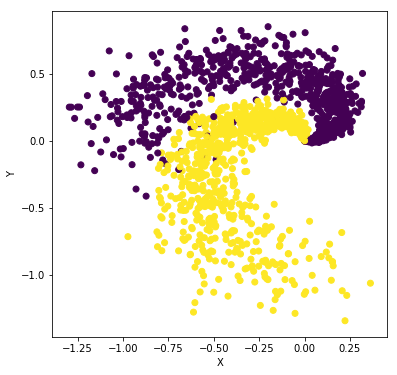

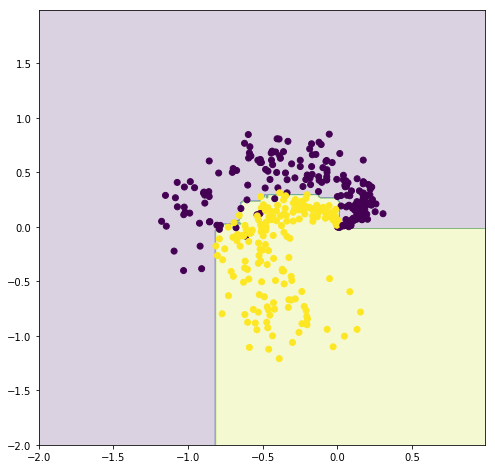

In [7]:
plot_result(model, dataTest, labelTest.values)

## Discussion

The nimbusml FastTreeBinarizer can not only be used for classification problem but also ranking and regression problems as in Burges (2010). Because of the factorization of gradients into the contribution of each data point, the algorithm can be implemented using mini-batch, which leds to significant speed up compared to the RankNet training (Burges, 2010). The method have proven to be very successful for many ranking problems as well.

### Ensemble Algorithm

In this section, we show the effects of increasing model complexity by introducing larger trees and increasing number of trees in the ensemble method. By increasing the model complexity, the decision boundry becomes more complicated.

In [8]:
if not os.path.exists('images'):
    os.makedirs('images')
    
if not os.path.isfile('images/ani_1.1.gif'):
    import matplotlib.animation as animation
    fig, ax = plt.subplots(figsize=(6,6))
    plt.close()
    def update(i):
        ax.clear()
        scat = ax.scatter(dataTest["X"], dataTest["Y"], c = labelTest)
        xx, yy = np.meshgrid(np.arange(-2,1,0.01),np.arange(-2,2,0.01))
        xx1 = np.array(xx).flatten()
        yy1 = np.array(yy).flatten()
        model = FastForestBinaryClassifier(num_leaves = min(i + 2, 20), num_trees = i * 2 + 1)
        model.fit(dataTrain, labelTrain) # Train the model        
        _predict = np.array(model.predict(pd.DataFrame({"X": xx1, "Y": yy1})))
        cont = ax.contourf(xx,yy,_predict.reshape((400,300)), alpha = 0.2).collections
        text = ax.set_title('Index ' + str(i))
        return cont + [scat] + [text]

    ani = animation.FuncAnimation(fig, update, frames = 8, interval = 800, blit=False)
    ani.save('images/ani_1.1.gif', dpi=80, writer='imagemagick')
Image(url='https://raw.githubusercontent.com/zyw400/image_dataset/master/ani_1.1.gif')